This method uses the Okubo–Weiss parameter following the method described in:
[1] https://link.springer.com/content/pdf/10.1007/s10236-013-0680-7.pdf

Limitation:
- noise in the W field
- detects an excess of eddies (Sadarjoenand Post 2000; Chaigneau et al. 2008)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib notebook

Read data

In [2]:
from scipy.io import netcdf_file

# https://resources.marine.copernicus.eu/product-download/SEALEVEL_EUR_PHY_L4_MY_008_068
f = netcdf_file("data2.nc")
lat = f.variables['latitude'].data
long = f.variables['longitude'].data
vel_x = f.variables['ugos'].data.squeeze()
vel_y = f.variables['vgos'].data.squeeze()


# fill in missing values
from common_functions import interpolate_missing_point

imputed_vel_x = interpolate_missing_point(vel_x, np.ma.masked_invalid(vel_x).mask)
imputed_vel_y = interpolate_missing_point(vel_y, np.ma.masked_invalid(vel_y).mask)

## Compute the Okubo-Weiss parameter

<IPython.core.display.Javascript object>


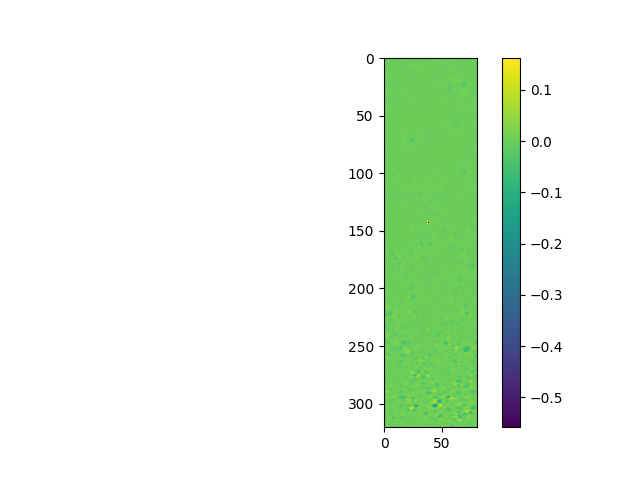

In [3]:
from common_functions import compute_okubo_weiss_parameter

W = compute_okubo_weiss_parameter(imputed_vel_x, imputed_vel_y)

plt.figure()
plt.imshow(W)
plt.colorbar()

## Compute threshold for an Eddie

Define an Eddie as a region where $W < W_0$. The threshold is defined as $W_0 = -0.2\sigma_W$ where $\sigma_W$ is the spatial standard devation of $W$.

In [4]:
W_0 = -0.2 * np.std(W)
W_0

-0.0021519386854448696

## Threshold data

<IPython.core.display.Javascript object>


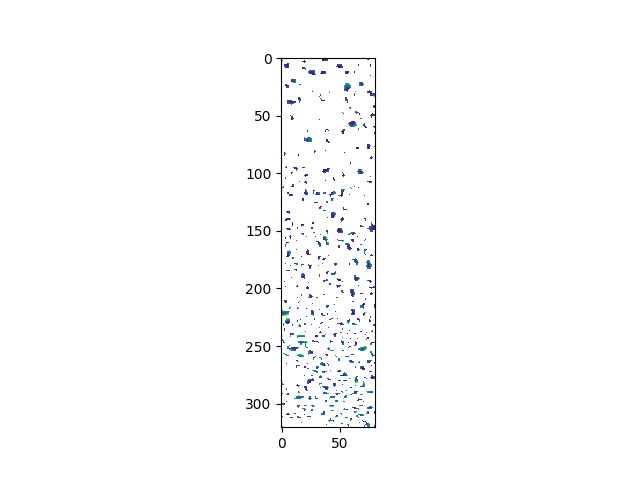

In [5]:
W_eddies = np.ma.masked_where(W > W_0, np.hypot(imputed_vel_x, imputed_vel_y))

plt.figure()
plt.imshow(W_eddies)

<IPython.core.display.Javascript object>


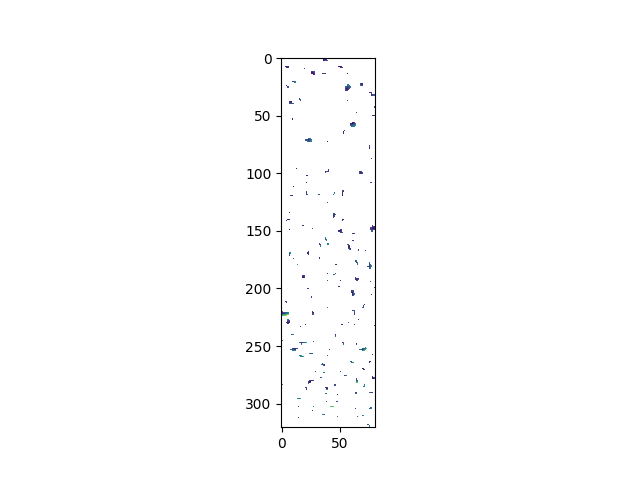

In [10]:
# here we can apply a minimum size citerion just need to decide what
W_eddies = np.ma.where(W < W_0, W, 0)
from scipy import ndimage
W_eddies = ndimage.maximum_filter(W_eddies, size=(2,2))
W_eddies = np.ma.masked_where(W_eddies == 0, np.hypot(imputed_vel_x, imputed_vel_y))
plt.figure()
plt.imshow(W_eddies)